# 预测房价-回归问题

前两个例子都是分类问题,目标是预测输入数据的对应的单一标签.而机器学习的另一大类是回归问题,目标是预测一个或多个连续值.例如根据气象条件预测气温等等.

ps: 回归(regression) 和 回归算法(logistic regression),没什么关系,而且 回归算法(logistic regression) 还不是回归问题的算法,回归算法(logistic regression) 是分类问题的一类算法..


## 准备数据


In [1]:
from tensorflow.keras.datasets import boston_housing
(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

In [4]:
print(train_data.shape, test_data.shape)
print(train_data[0])
print(train_targets[0])


(404, 13) (102, 13)
[  1.23247   0.        8.14      0.        0.538     6.142    91.7
   3.9769    4.      307.       21.      396.9      18.72   ]
15.2


波士顿房价数据集,是 1970 年代波士顿房价中位数还有附件犯罪率/房产税等等的数据集.与前两个例子完全不同.

- 样本数量少得多,训练数据 404,测试数据,102.一个样本有 13 个维度.
- 样本每个维度的取值范围均不相同.
- 房屋价格是中位数,单位是 千美元.


In [5]:
mean = train_data.mean(axis=0)  #均值
train_data -= mean
std = train_data.std(axis=0)  #标准差
train_data /= std
test_data -= mean  #测试数据
test_data /= std

输入数据范围差距很大,如果是神经网络自适应,会加大学习的难度.因此最好是预处理一下.

特征标准化 = (特征值 - 均值) / 标准差

**取均值/标准差** 绝对不要使用测试集,在模型验证之前,不能从测试集获取任何信息!!


## 构建 model


In [6]:
from tensorflow import keras
from tensorflow.keras import layers


def build_model():  #后面还要有多次实例化,写成函数
    model = keras.Sequential([
        layers.Dense(64, activation='relu'),
        layers.Dense(64, activation='relu'),
        layers.Dense(1)
    ])
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    return model


样本数量非常少,可能面临相对严重的过拟合.使用较小的模型可以一定程度上缓解这个问题.

model

- 输出层只有一个单元,输出一个标量.没有激活函数,所以输出值值域没有限定.
- 损失函数改为了 `mse` 均方误差,预测值与目标值之差的平方.(回归问题常用)
- 指标改为了 平均绝对误差 (MAE),预测值与目标值之差的绝对值.


## K 折交叉验证

样本数量过少,不止容易过拟合,还很难分出合适的验证集.

- 验证集样本数量贴别少,无从验证.
- 验证集取样位置,影响验证结果.

这种情况下最好的做法是 K 折交叉验证


K 折交叉验证

- 可用数据分为 K 个分区 (4,5 常见).
- 实例化 K 个相同模型.
- 迭代 K 次,第 i 个分区数据验证,其他 K-1 个分区训练.
- 最好结果是 K 个验证分数的均值.

[K 折交叉验证](./3-fold-cross-validation.png)


In [9]:
import numpy as np

k = 4
num_val_samples = len(train_data) // k
num_epochs = 100
all_scores = []
for i in range(k):
    print(f"Processing fold #{i}")  #轮次
    val_data = train_data[i * num_val_samples: \
                                (i + 1) * num_val_samples]  #取 i 轮验证数据
    val_targets = train_targets[i * num_val_samples: \
                                    (i + 1) * num_val_samples]  #取 i 轮验证数据
    partial_train_data = np.concatenate([
        train_data[:i * num_val_samples],
        train_data[(i + 1) * num_val_samples:]],\
        axis=0)  # i 轮训练数据
    partial_train_targets = np.concatenate([
        train_targets[:i * num_val_samples],
        train_targets[(i + 1) * num_val_samples:]],\
        axis=0)  # i 轮训练数据
    model = build_model()  # 获取模型
    model.fit(partial_train_data,
              partial_train_targets,
              epochs=num_epochs,
              batch_size=16,
              verbose=0)  # verbose=0 关闭输出,静默模式
    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)  #验证结果
    all_scores.append(val_mae)

Processing fold #0
Processing fold #1
Processing fold #2
Processing fold #3


In [10]:
print(all_scores)
np.mean(all_scores)

[1.9347295761108398, 2.5065197944641113, 2.454893112182617, 2.3161709308624268]


2.303078353404999

平均的偏差到了 2.3 差不多是 $2300,效果还是差很多.


In [11]:
num_epochs = 500
all_mae_histories = []
for i in range(k):
    print(f"Processing fold #{i}")  #轮次
    val_data = train_data[i * num_val_samples:(i + 1) * num_val_samples]  #验证数据
    val_targets = train_targets[i * num_val_samples:(i + 1) * num_val_samples]
    partial_train_data = np.concatenate([
        train_data[:i * num_val_samples],
        train_data[(i + 1) * num_val_samples:]
    ],
                                        axis=0)  #训练数据
    partial_train_targets = np.concatenate([
        train_targets[:i * num_val_samples],
        train_targets[(i + 1) * num_val_samples:]
    ],
                                           axis=0)
    model = build_model()
    history = model.fit(partial_train_data,
                        partial_train_targets,
                        validation_data=(val_data, val_targets),
                        epochs=num_epochs,
                        batch_size=16,
                        verbose=0)  #静默
    mae_history = history.history["val_mae"]
    all_mae_histories.append(mae_history)

Processing fold #0
Processing fold #1
Processing fold #2
Processing fold #3


训练轮次增加到 500,详细记录数据.


In [12]:
average_mae_history = [
    np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)
]


算出每一个轮次 K 折验证的均值

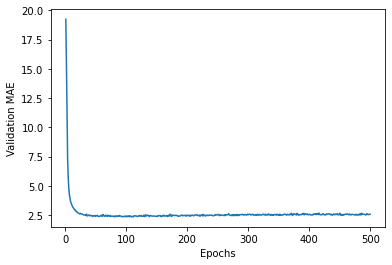

In [14]:
import matplotlib.pyplot as plt

plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel("Epochs")
plt.ylabel("Validation MAE")
plt.show()

因此前面几个与后面的数据差距太大,后面真正需要的数据反而看不清变化了,重绘


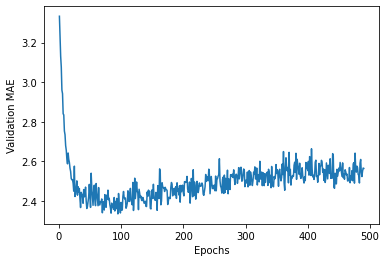

In [15]:
truncated_mae_history = average_mae_history[10:]  #去掉前10个数据
plt.plot(range(1, len(truncated_mae_history) + 1), truncated_mae_history)
plt.xlabel("Epochs")
plt.ylabel("Validation MAE")
plt.show()

差不多 mae 最低点是在 100 左右,加上忽略的 10 个点,过拟合是在 110 ~ 120 之间,和书上貌似提前了一些.


In [33]:
model = build_model()
model.fit(train_data, train_targets,
          epochs=130, batch_size=16, verbose=0)
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)

4/4 [==============================] - 0s 2ms/step - loss: 12.1270 - mae: 2.4050


In [34]:
test_mae_score

2.405019760131836

最终还是按照书上取 130 吧,这样最后的结果是 2.4 左右..


## 应用 model

In [37]:
predictions = model.predict(test_data)
print(predictions[0])
print(test_targets[0])

[6.9066005]
7.2


第一个结果与预测值只相差了 300 美元,似乎比书上的结果更好一点..


## 结论

与分类问题不同,回归问题使用的损失函数一般是 均方误差(mse),常用的指标是 平均绝对误差(mae)

如果输入的特征取值范围相差很大,应当进行预处理,对每个特征单独缩放.这里是特征标准化,**无论如何不能从测试集抽取信息**

可用样本数据很少,一个做法是 K 折验证.

一个较小的模型可以一定程度上缓解过拟合.
